Created on 4.19.24 by Kyle Wong for Vincent at VivSoft

**Task**: Vincent asked me to send an example Tableau report over. I don't have one available, nor am I able to use any professional work I've done since it's all locked behind NDAs.

I'm a firm believer that visuals and storytelling with data are only as impactful as the raw data under the hood. So, I'm using this Python notebook to add some features to a random dataset I found off Kaggle in an attempt to beef up the impact factor of my final deliverable: https://www.kaggle.com/datasets/ishanshrivastava28/superstore-sales/data

**Scenario**: I've been hired by an online retailer to create a Tableau report to measure their sales and delivery performance. They'd like me to create new geographic groupings and visualize KPI breakdowns by these new groupings in order to investigate possible geography-based trends.

# Load Dataset

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [94]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [95]:
def create_df_from_shareable_link(shareable_link):
  id = shareable_link.split('/d/')[1].split('/')[0]
  downloaded = drive.CreateFile({'id':id})
  downloaded.GetContentFile('Filename.csv')
  df_temp = pd.read_csv('Filename.csv', encoding='iso-8859-1')
  return df_temp

In [96]:
superstore_link = "https://drive.google.com/file/d/1EbhMuynviAMbTzca7MSQngQYveOig3J1/view?usp=drive_link"
df = create_df_from_shareable_link(superstore_link)

# Super Quick Clean

Nothing serious - just cleaning up the dataset for visualization

In [97]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [98]:
df.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

In [99]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format="%d-%m-%Y")
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format="%d-%m-%Y")

In [100]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2013-138688,2013-06-13,2013-06-17,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


# Feature Engineering - Add Location Coordinates

In [101]:
def get_lat_long(city_state_name):
    """
    Get latitude and longitude based on a city name using the OpenStreetMap Nominatim service.

    Args:
    - city_name (str): Name of the city.

    Returns:
    - Tuple (latitude, longitude) if successful, None otherwise.
    """

    # Initialize Nominatim geocoder
    geolocator = Nominatim(user_agent="geo_locator")

    try:
        # Geocode the city name to get location information
        location = geolocator.geocode(city_state_name)

        if location:
            # Extract latitude and longitude from the location object
            latitude = location.latitude
            longitude = location.longitude
            return latitude, longitude
        else:
            print(f"No location found for {city_state_name}.")
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [102]:
df['City_State'] = df['City'] + ', ' + df['State']

In [103]:
unique_city_state_combos = df['City_State'].unique()
city_coordinates = {}
for city_state in unique_city_state_combos:
  temp_lat, temp_long = get_lat_long(city_state)
  city_coordinates[city_state] = {
      'latitude':temp_lat,
      'longitude':temp_long
  }

In [104]:
df['Latitude'] = df['City_State'].map(lambda x: city_coordinates[x]['latitude'])
df['Longitude'] = df['City_State'].map(lambda x: city_coordinates[x]['longitude'])

# Group Sales by Location and Sales Value

### Determine optimal cluster size

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

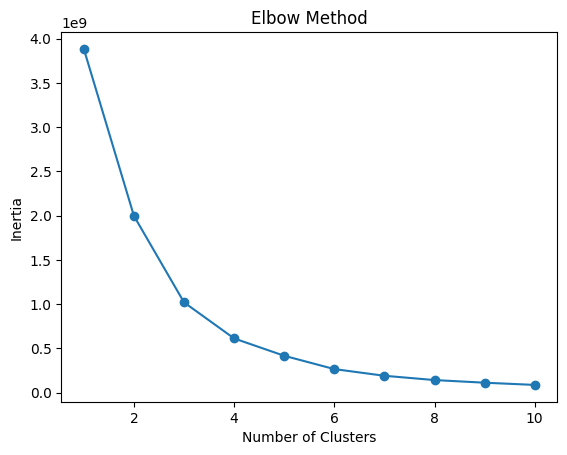

In [105]:
def elbow_method(data, max_clusters):
    """
    Perform elbow method to determine the optimal number of clusters.

    Args:
    - data (DataFrame): The dataset to be clustered.
    - max_clusters (int): The maximum number of clusters to consider.

    Returns:
    - None (plots the elbow curve)
    """
    # Initialize list to store inertia values
    inertia = []

    # Fit KMeans models for different values of k
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

# Example usage
# Replace 'data' with your dataset containing latitude and longitude coordinates
elbow_method(df[['Latitude','Longitude', 'Sales']], max_clusters=10)

Will group into 4 clusters

### KMeans

In [106]:
def superstore_kmeans(df, num_clusters, pca_clusters):
  """Cluster transactions"""

  # pca = PCA(n_components=pca_clusters, random_state=123)
  # X = pca.fit_transform(df)

  kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=123)
  kmeans.fit(df)

  # Get the cluster labels for each review
  cluster_labels = kmeans.labels_

  # get inertia for compactness; lower inertia indicates tighter clusters
  cluster_inertia = kmeans.inertia_

  return cluster_labels, cluster_inertia

In [107]:
cluster_labels, cluster_inertia = superstore_kmeans(df[['Latitude','Longitude']], num_clusters=4, pca_clusters=3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [108]:
# get distribution of clustering
unique_values, counts = np.unique(cluster_labels, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 2563
1: 3291
2: 3483
3: 657


In [109]:
df['kmeans_cluster'] = cluster_labels

Visualize results to sense-check

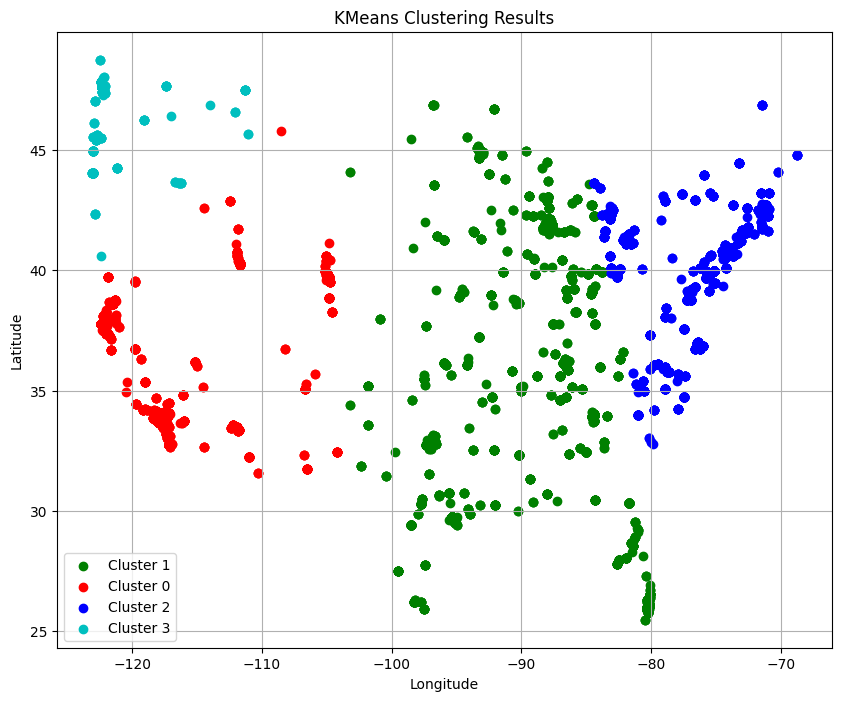

In [110]:
plt.figure(figsize=(10, 8))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Define colors for each cluster

for cluster_id in df['kmeans_cluster'].unique():
    cluster_df = df[df['kmeans_cluster'] == cluster_id]
    plt.scatter(cluster_df['Longitude'], cluster_df['Latitude'], color=colors[cluster_id], label=f'Cluster {cluster_id}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMeans Clustering Results')
plt.legend()
plt.grid(True)
plt.show()

# Export to csv

In [111]:
df.to_csv('Superstore_kmeans.csv', index=False)